<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [50]:
(2+9+8+7+6+6)/12

3.1666666666666665

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(base_transformer_model: Union[str, nn.Module]):
        self.backbone = #...
        # YOUR CODE: create additional layers for classfication

    def forward(inputs, ...):
        # YOUR CODE: propagate inputs through the model. Return dict with logits

        outputs = {<YOUR CODE>}
        return # YOUR CODE

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    pass

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
import copy

def train_transformer(transformer_model, freeze_backbone=True)
    model = copy.copy(transformer_model)
    ### YOUR CODE IS HERE

    return finetuned_model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
rubert_tiny_transformer_model = #...
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, freeze_backbone=True)

rubert_tiny_transformer_model = #...
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, freeze_backbone=False)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
### YOUR CODE IS HERE (probably, similar on the previous step)

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
    pass

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
### YOUR CODE IS HERE

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

In [ ]:
### YOUR CODE IS HERE

# Решение задания

In [1]:
# Подключаем необходимый импорт библиотек
import pandas as pd
from tqdm import tqdm
from typing import Union

import copy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer
from transformers import AutoModel, AutoConfig
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
# Загружаем сырой датасет и смотрим статистику по классам
df = pd.read_csv("data_problems_translated.csv")
df["topic"].value_counts(dropna=False)

topic
number_theory    2396
combinatorics    1020
dirichlet         441
polynoms          426
graphs            384
geometry          371
invariant         235
Name: count, dtype: int64

In [3]:
'''Проведем небольшой анализ текстов, если текст встречается более 1 раза то смотрим отдельно на такие тексты. 
Особое внимание обращем на тексты, которые встречаются более одного раза, но при этом эти тексты относятся к разным классам,
так как это явно ошибочные данные, которые стоит удалить.
'''
text_stats = df["problem_text"].value_counts().reset_index()

In [4]:
suspected_texts = []

for text in text_stats[text_stats["count"]>1]["problem_text"].to_list():
    if df[df["problem_text"]==text]["topic"].nunique() > 2 and len(text) < 70:
        suspected_texts.append(text)

In [5]:
# Удалим данный список текстов из общего датафрейма, так как они выглядят довольно подозрительными и модель врятли чему-то сможет научиться на таких текстах
print(f"Кол-во данных до удаления {df.shape[0]}")
df = df[~df["problem_text"].isin(suspected_texts)]
print(f"Кол-во данных после удаления {df.shape[0]}")

Кол-во данных до удаления 5273
Кол-во данных после удаления 5219


In [6]:
num_classes = df["topic"].nunique()
print(f"Кол-во уникальных классов из датасета: {num_classes}")

Кол-во уникальных классов из датасета: 7


In [7]:
# заводим переменную device, что бы вычисления шли на графическом ускорителе
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

# Задание 1

In [8]:
'''Создаем класс в который мы передаем базовую модель или же какую-то другую модель, 
а также передаем кол-во классов на которое мы будет классифицировать'''

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_classes: int):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, **inputs):
        backbone_outputs = self.backbone(**inputs)
        hidden_states = backbone_outputs.last_hidden_state  # Получаем скрытые состояния
        logits = self.classifier(hidden_states[:, 0, :])  # Используем [CLS] токен
        return {"logits": logits}

# Задание 2

In [9]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

# Задание 3

In [10]:
'''
Добавим в процедуру обучения момент сохранения данных в Тензорборд, для дальнейшего их просмотра и анализа.
'''
def train_transformer(transformer_model:nn.Module,
                      model_name: str,
                      device: str, 
                      num_epochs: int, 
                      writer,
                      train_dataloader,
                      freeze_backbone:bool=True):
    model = copy.copy(transformer_model)
    
    # замораживаем веса если нужно
    if freeze_backbone:
        model = freeze_backbone_function(model)
    
    # переносим вычисление модели на нужное устройство
    model.to(device)

    # Определяем функцию потерь и оптимизатор
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    # В этот список мы будем сохранять наши лоссы, 
    losses = []
    
    # Цикл обучения
    model.train()
    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        epoch_loss = 0.0
        batch_losses = []
        for batch in train_dataloader:
            
            inputs = {key: value.to(device) for key, value in batch["inputs"].items()}
            labels = batch["labels"].to(device)  # Переносим метки классов на устройство

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(**inputs)
            logits = outputs["logits"]

            # Вычисляем функцию потерь
            loss = criterion(logits, labels)
            batch_losses.append(loss.item())
            writer.add_scalar(f"Loss/train/{model_name}", loss, epoch)
            epoch_loss += loss.item()

            # Обратный проход
            loss.backward()
            optimizer.step()
        
        losses.append(sum(batch_losses)/len(batch_losses))
        writer.flush()
    return {"model": model, "losses": losses}

# Задание 4

In [11]:
# Подготовим DataSet из исходного файла на котором и будем обучаться
df.dropna(subset=['problem_text', 'topic'], inplace=True)

# Проверим уникальные классы в столбце "topic" и создадим маппинг
topic_to_idx = {topic: idx for idx, topic in enumerate(df['topic'].unique())}

# Добавляем числовые метки для классов
df['label'] = df['topic'].map(topic_to_idx)

# Создаём Dataset
class MathProblemsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Получаем текст задачи и метку
        text = self.data.iloc[idx]['problem_text']
        label = self.data.iloc[idx]['label']

        # Токенизация текста
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "inputs": {key: val.squeeze(0) for key, val in inputs.items()},
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [12]:
bert_model_name = 'cointegrated/rubert-tiny2'

# Используем токенизатор из той же самой модели, на которой мы проводим эксперименты
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Разделение данных
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Создание датасетов
train_dataset = MathProblemsDataset(train_data, tokenizer)
test_dataset = MathProblemsDataset(test_data, tokenizer)

# DataLoader для обучения модели
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
num_epochs = 20
# объект класса SummaryWriter необходимый для записи данных в тензорборд
writer = SummaryWriter(log_dir="tensorboard_logs")

# обучаем модель с замороженным backbone
rubert_tiny_transformer_model_freezed = TransformerClassificationModel(base_transformer_model=bert_model_name,
                                                               num_classes=num_classes)

rubert_tiny_freezed_result = train_transformer(rubert_tiny_transformer_model_freezed,
                                                                model_name=f'{bert_model_name}_freezed',
                                                                num_epochs=num_epochs,
                                                                device = device,
                                                                writer=writer,
                                                                train_dataloader=train_dataloader,
                                                                freeze_backbone=True)

Training Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.56s/it]


In [14]:
# обучаем модель с размороженным backbone
rubert_tiny_transformer_model_unfreezed = TransformerClassificationModel(base_transformer_model=bert_model_name,
                                                               num_classes=num_classes)
rubert_tiny_unfreezed_result = train_transformer(rubert_tiny_transformer_model_unfreezed,
                                               model_name=f'{bert_model_name}_unfreezed',
                                               num_epochs=num_epochs,
                                               device = device,
                                               writer=writer,
                                               train_dataloader=train_dataloader,
                                               freeze_backbone=False)

Training Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:51<00:00, 17.58s/it]


Вычислим на тестовой выборке итоговую метрику качества. В качестве метрики будем использовать weighted F1 скор, так как у нас классы не сбалансированы

In [15]:
def compute_f1_weighted(model, test_dataloader, device):
    model.eval()  # Переводим модель в режим оценки (без градиентов)

    all_preds = []  # Список для хранения предсказаний
    all_labels = []  # Список для хранения реальных меток

    # Прогоняем тестовые данные через модель
    with torch.no_grad():
        for batch in test_dataloader:
            # Переносим данные на нужное устройство
            inputs = {key: value.to(device) for key, value in batch["inputs"].items()}
            labels = batch["labels"].to(device)

            # Получаем предсказания от модели
            outputs = model(**inputs)
            logits = outputs["logits"]

            # Получаем классы с максимальной вероятностью (предсказания)
            _, preds = torch.max(logits, dim=1)

            # Сохраняем предсказания и метки
            all_preds.extend(preds.cpu().numpy())  # Переносим на CPU и конвертируем в массив
            all_labels.extend(labels.cpu().numpy())

    # Вычисляем F1-weighted score
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    return f1_weighted

In [16]:
f1_weighted_score_rubert_freezed = compute_f1_weighted(rubert_tiny_freezed_result['model'], test_dataloader, device)
print(f"F1-weighted score rubert freezed: {f1_weighted_score_rubert_freezed}")

F1-weighted score rubert freezed: 0.5538398354862332


In [17]:
f1_weighted_score_rubert_unfreezed = compute_f1_weighted(rubert_tiny_unfreezed_result['model'], test_dataloader, device)
print(f"F1-weighted score rubert unzfreezed: {f1_weighted_score_rubert_unfreezed}")

F1-weighted score rubert unzfreezed: 0.29216531585073535


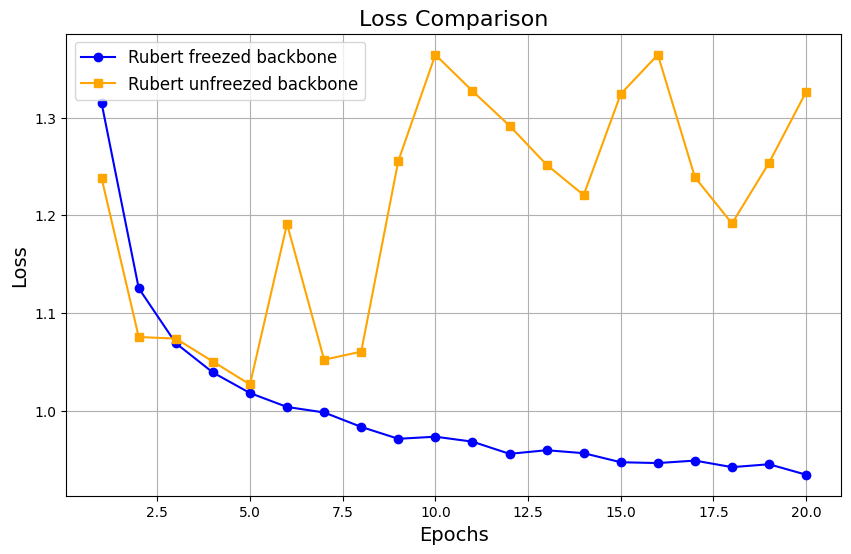

In [18]:
import matplotlib.pyplot as plt

# Эпохи (или шаги), соответствующие значениям функции потерь
epochs = range(1, len(rubert_tiny_freezed_result['losses']) + 1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, rubert_tiny_freezed_result['losses'], label="Rubert freezed backbone", color="blue", marker="o")
plt.plot(epochs, rubert_tiny_unfreezed_result['losses'], label="Rubert unfreezed backbone", color="orange", marker="s")

# Настройка графика
plt.title("Loss Comparison", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Отображение графика
plt.show()

# Задание 5

In [19]:
math_model_name = 'tbs17/MathBert'

# Токенайзер из модели
math_tokenizer = AutoTokenizer.from_pretrained(math_model_name)

# Разделение данных
math_train_data, math_test_data = train_test_split(df, test_size=0.2, random_state=42)

# Создание датасетов
math_train_dataset = MathProblemsDataset(math_train_data, math_tokenizer)
math_test_dataset = MathProblemsDataset(math_test_data, math_tokenizer)

# DataLoader для обучения модели
math_train_dataloader = DataLoader(math_train_dataset, batch_size=16, shuffle=True)
math_test_dataloader = DataLoader(math_test_dataset, batch_size=16, shuffle=False)

In [20]:
# обучаем модель с замороженным backbone
math_model_freezed = TransformerClassificationModel(base_transformer_model=math_model_name,
                                                               num_classes=num_classes)
math_freezed_result = train_transformer(math_model_freezed,
                                                                model_name=f"{math_model_name}_freezed",
                                                                num_epochs=num_epochs,
                                                                device = device,
                                                                writer=writer,
                                                                train_dataloader=math_train_dataloader,
                                                                freeze_backbone=True)

Training Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:09<00:00, 45.48s/it]


In [21]:
# обучаем модель с размороженным backbone
math_model_unfreezed = TransformerClassificationModel(base_transformer_model=math_model_name,
                                                               num_classes=num_classes)
math_unfreezed_result = train_transformer(math_model_unfreezed,
                                                                model_name=f"{math_model_name}_unfreezed",
                                                                num_epochs=num_epochs,
                                                                device = device,
                                                                writer=writer,
                                                                train_dataloader=math_train_dataloader,
                                                                freeze_backbone=False)

Training Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:05:59<00:00, 197.97s/it]


In [22]:
f1_weighted_score_math_freezed = compute_f1_weighted(math_freezed_result["model"], math_test_dataloader, device)
print(f"F1-weighted score math based model freezed: {f1_weighted_score_math_freezed}")

F1-weighted score math based model freezed: 0.5169424027104873


In [23]:
f1_weighted_score_math_unfreezed = compute_f1_weighted(math_unfreezed_result["model"], math_test_dataloader, device)
print(f"F1-weighted score math based model freezed: {f1_weighted_score_math_unfreezed}")

F1-weighted score math based model freezed: 0.2626056711123396


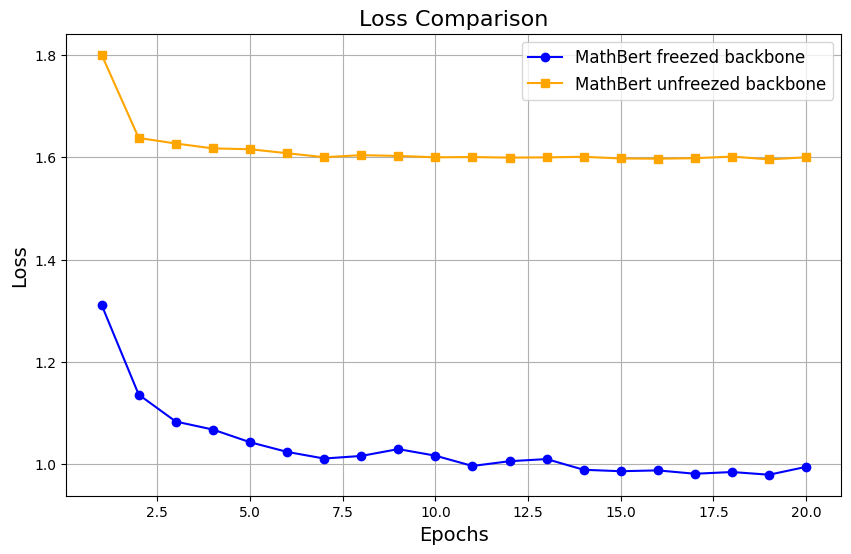

In [24]:
# Эпохи (или шаги), соответствующие значениям функции потерь
epochs = range(1, len(math_freezed_result['losses']) + 1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, math_freezed_result['losses'], label="MathBert freezed backbone", color="blue", marker="o")
plt.plot(epochs, math_unfreezed_result['losses'], label="MathBert unfreezed backbone", color="orange", marker="s")

# Настройка графика
plt.title("Loss Comparison", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Отображение графика
plt.show()

# Задание 6

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
from typing import List

def draw_first_layer_attention_maps(
    attention_head_id: int,
    sentence1: str,
    sentence2: str,
    model: TransformerClassificationModel,
    tokenizer_name: str
):
    """
    Функция для отрисовки двух раздельных карт внимания (для каждого предложения).

    Parameters:
    - attention_head_id: Номер головы внимания для визуализации.
    - sentence1: Первое предложение.
    - sentence2: Второе предложение.
    - model: Модель трансформера.
    - tokenizer_name: Название токенизатора, чтобы токенизировать текст.
    """
    # Токенизация предложений
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    inputs1 = tokenizer(sentence1, return_tensors="pt")
    inputs2 = tokenizer(sentence2, return_tensors="pt")

    model.to("cpu")
    model.eval()

    # Получение карты внимания для первого предложения
    with torch.no_grad():
        outputs1 = model.backbone(
            input_ids=inputs1["input_ids"],
            attention_mask=inputs1["attention_mask"],
            output_attentions=True,  # Включаем возвращение карт внимания
        )
    attention1 = outputs1.attentions[0]  # Карта внимания для первого слоя
    attention_head1 = attention1[0, attention_head_id].cpu().numpy()

    # Получение карты внимания для второго предложения
    with torch.no_grad():
        outputs2 = model.backbone(
            input_ids=inputs2["input_ids"],
            attention_mask=inputs2["attention_mask"],
            output_attentions=True,  # Включаем возвращение карт внимания
        )
    attention2 = outputs2.attentions[0]  # Карта внимания для первого слоя
    attention_head2 = attention2[0, attention_head_id].cpu().numpy()

    # Получаем токены для каждого предложения
    tokens1 = tokenizer.convert_ids_to_tokens(inputs1["input_ids"].squeeze().tolist())
    tokens2 = tokenizer.convert_ids_to_tokens(inputs2["input_ids"].squeeze().tolist())

    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # График для первого предложения
    ax1 = axes[0]
    ax1.imshow(attention_head1, cmap="viridis", interpolation="nearest")
    ax1.set_xticks(np.arange(len(tokens1)))
    ax1.set_yticks(np.arange(len(tokens1)))
    ax1.set_xticklabels(tokens1, rotation=90, fontsize=8)
    ax1.set_yticklabels(tokens1, fontsize=8)
    ax1.set_title(f"Attention Map for Sentence 1 (Head {attention_head_id})")
    ax1.set_xlabel("Tokens")
    ax1.set_ylabel("Tokens")

    # График для второго предложения
    ax2 = axes[1]
    ax2.imshow(attention_head2, cmap="viridis", interpolation="nearest")
    ax2.set_xticks(np.arange(len(tokens2)))
    ax2.set_yticks(np.arange(len(tokens2)))
    ax2.set_xticklabels(tokens2, rotation=90, fontsize=8)
    ax2.set_yticklabels(tokens2, fontsize=8)
    ax2.set_title(f"Attention Map for Sentence 2 (Head {attention_head_id})")
    ax2.set_xlabel("Tokens")
    ax2.set_ylabel("Tokens")

    # Настраиваем общий вид графика
    plt.tight_layout()
    plt.show()

# Задание 7

In [26]:
bert_model_name = 'cointegrated/rubert-tiny2'
math_model_name = 'tbs17/MathBert'

rubert_without_train = TransformerClassificationModel(base_transformer_model=bert_model_name, num_classes=num_classes)
mathbert_without_train = TransformerClassificationModel(base_transformer_model=bert_model_name, num_classes=num_classes)

In [28]:
test_data.head()

,Unnamed: 0,problem_text,topic,label
1607,1607,The circle with centre D passes through the ve...,geometry,4
699,699,Five numbers are given; the sum of any three o...,number_theory,0
2480,2480,Prove that for any valid numbers a and b equal...,polynoms,1
4465,4465,Send a comment Decision Task 35044 Themes: [Th...,combinatorics,2
1528,1528,Ali Baba stands with a large bag of coins in t...,combinatorics,2


In [33]:
# тут больше текста
setence_1 = test_data.loc[1607]["problem_text"]

# тут есть формулы
setence_2 = test_data.loc[4572]["problem_text"]

## Ниже вычисляются различные карты внимания для различных голов

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


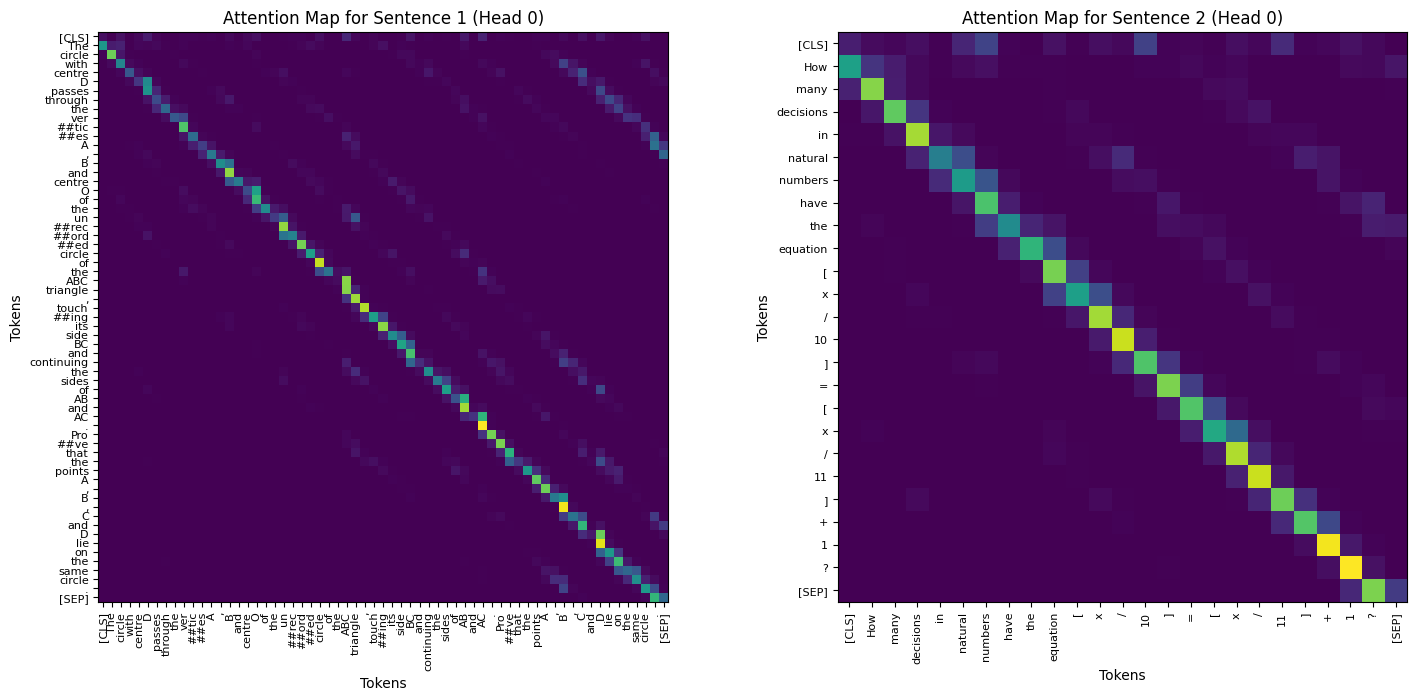

In [34]:
# Пример использования
attention_head_id = 0
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, rubert_without_train, bert_model_name)

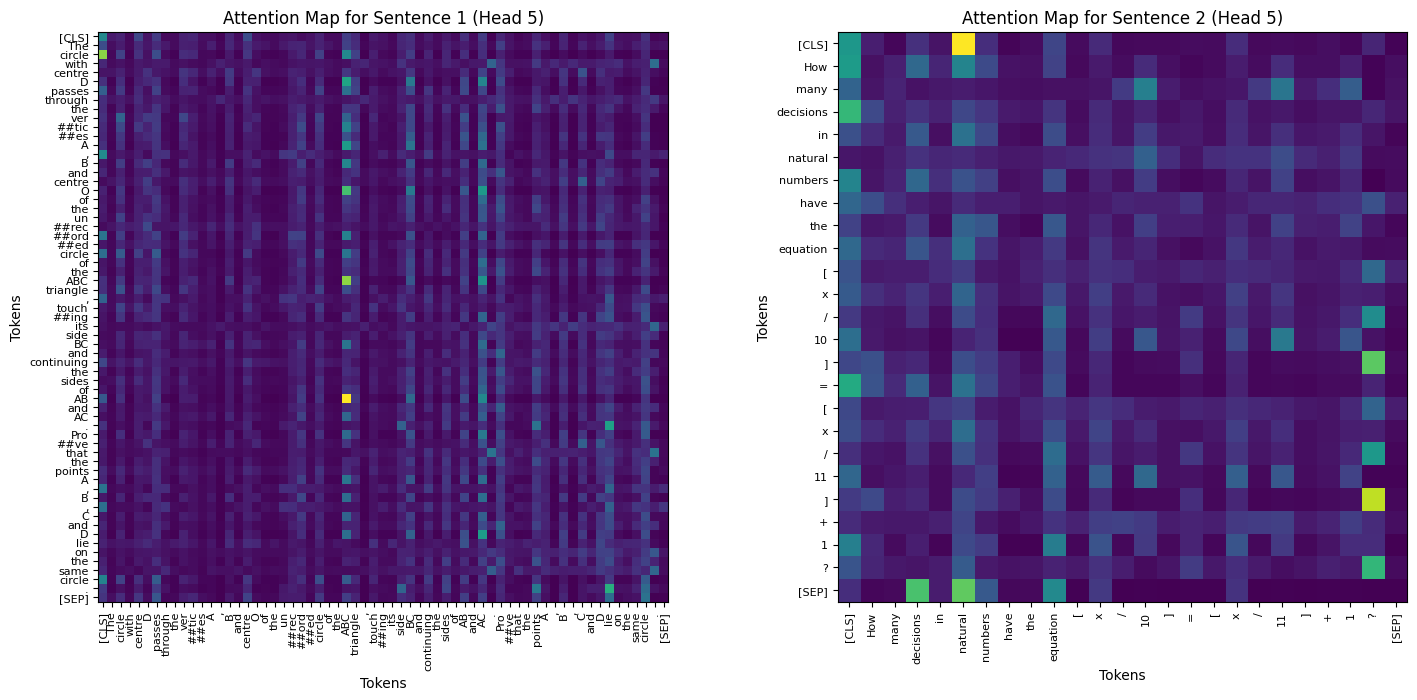

In [35]:
# Пример использования
attention_head_id = 5
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, rubert_without_train, bert_model_name)

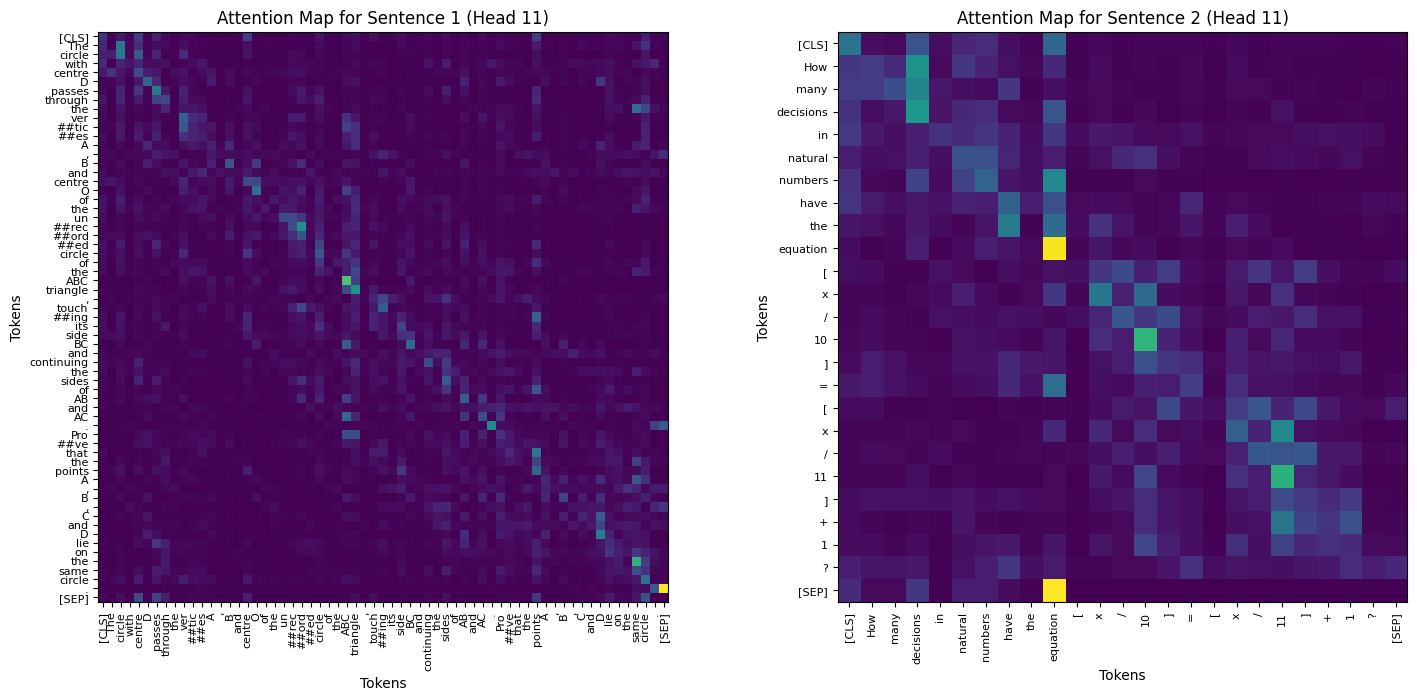

In [36]:
# Пример использования
attention_head_id = 11
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, rubert_without_train, bert_model_name)

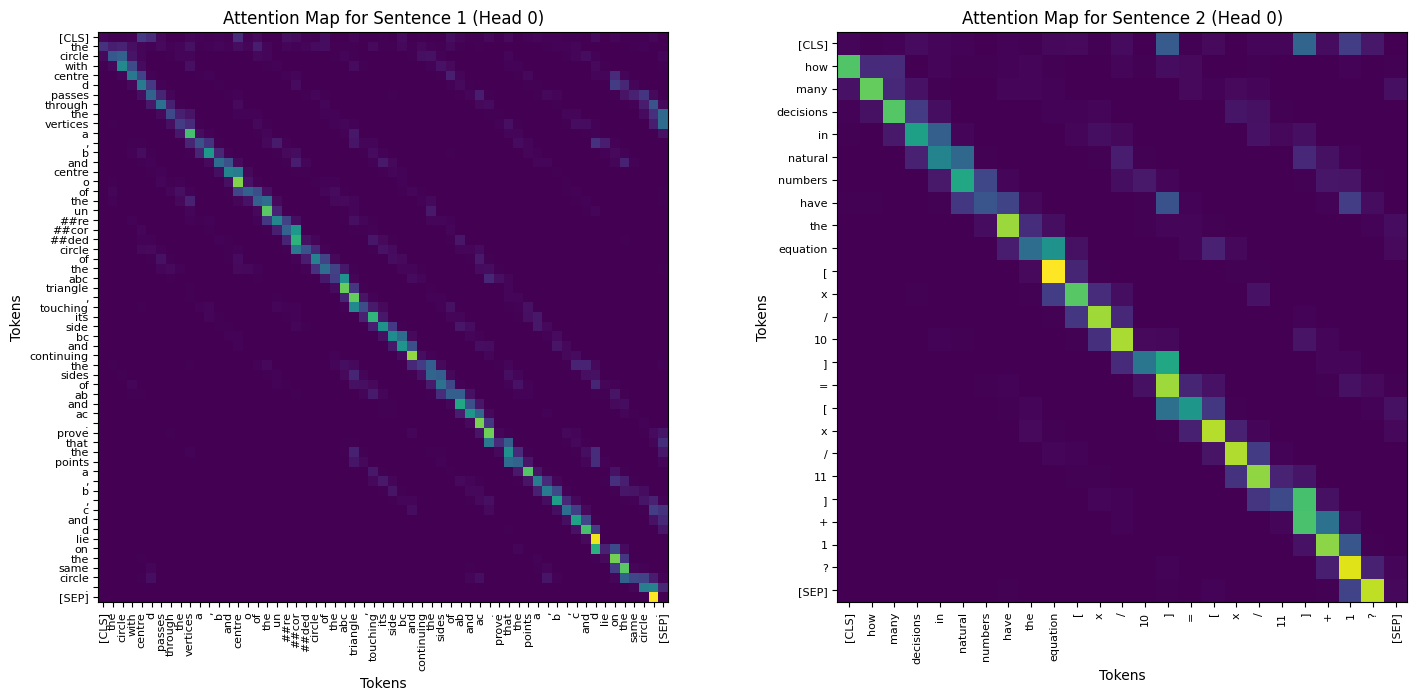

In [37]:
# Отрисуем карты внимания для тех же предложений, но для модели MathBert
attention_head_id = 0
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, mathbert_without_train, math_model_name)

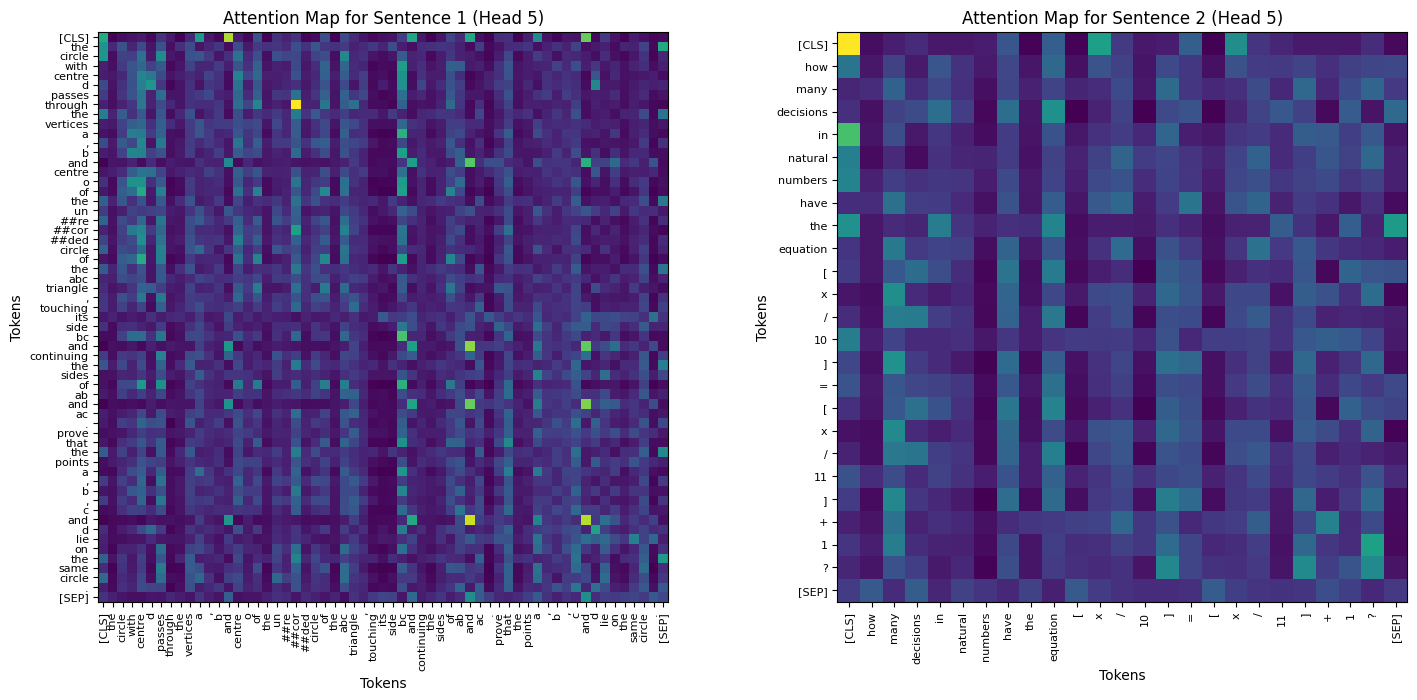

In [40]:
# Отрисуем карты внимания для тех же предложений, но для модели MathBert
attention_head_id = 5
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, mathbert_without_train, math_model_name)

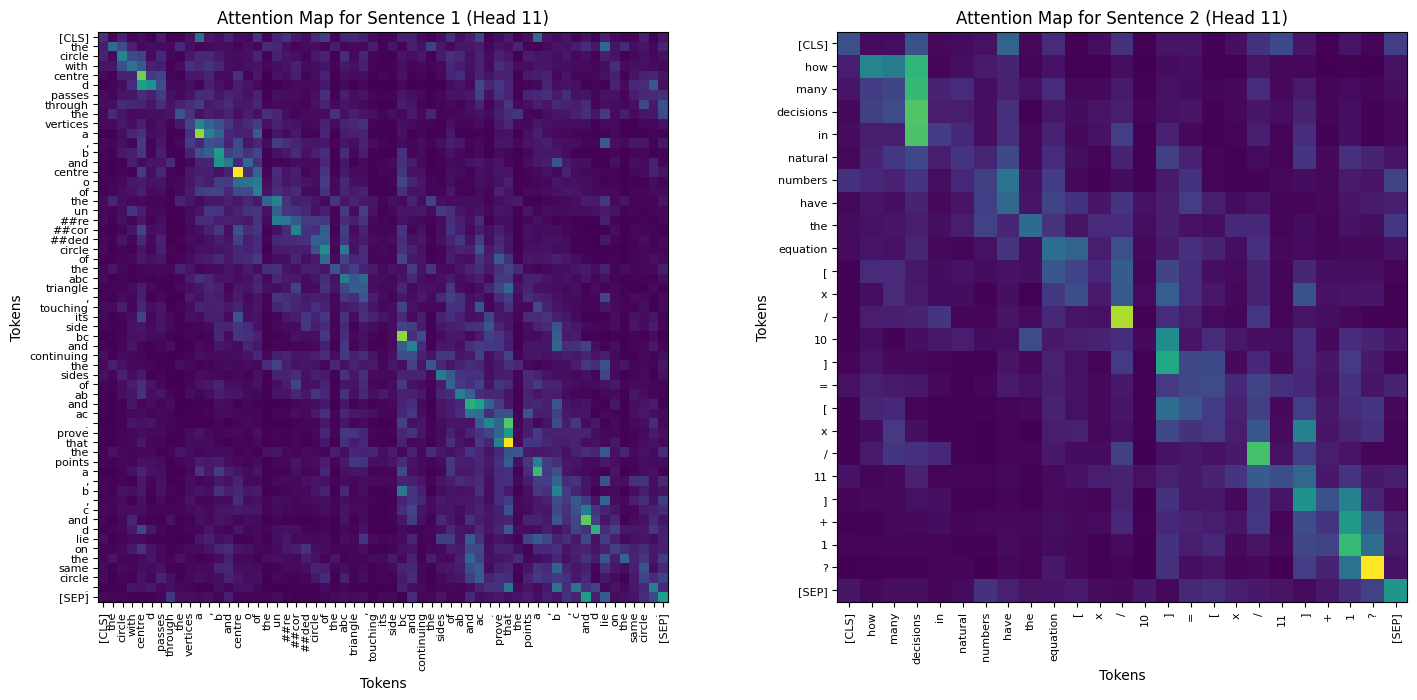

In [41]:
# Отрисуем карты внимания для тех же предложений, но для модели MathBert
attention_head_id = 11
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, mathbert_without_train, math_model_name)

# Задание 8

In [42]:
# так как результаты работы моделей у нас примерно одинаковые, поэтому будем отрисовывать карты внимания для моделей с замороженным backbone

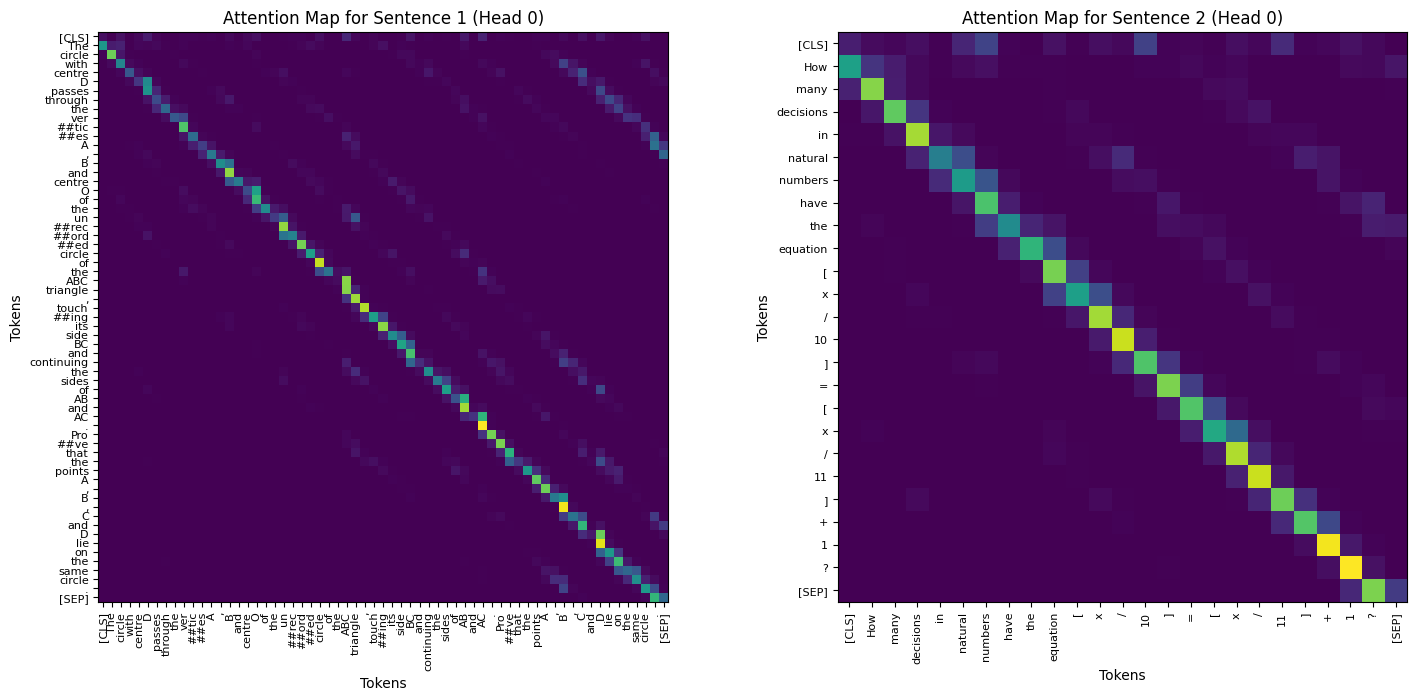

In [43]:
attention_head_id = 0
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, rubert_tiny_freezed_result['model'], bert_model_name)

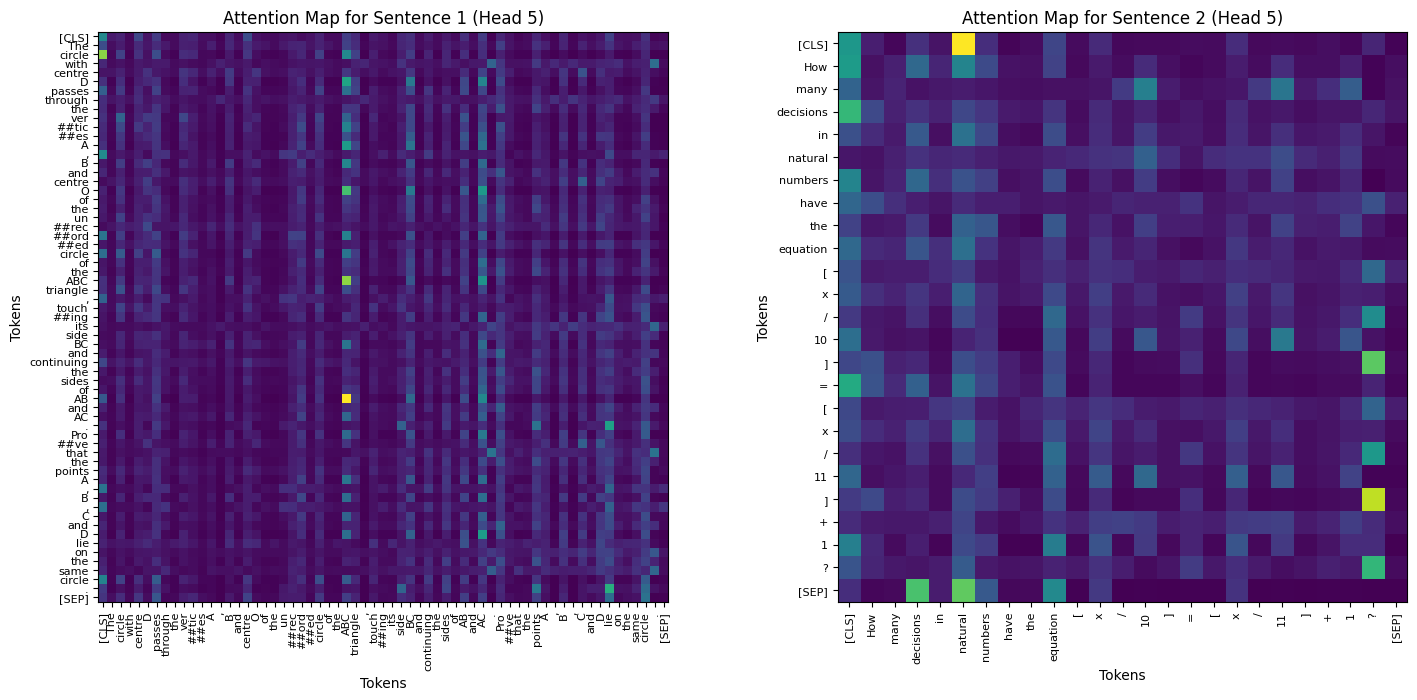

In [44]:
attention_head_id = 5
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, rubert_tiny_freezed_result['model'], bert_model_name)

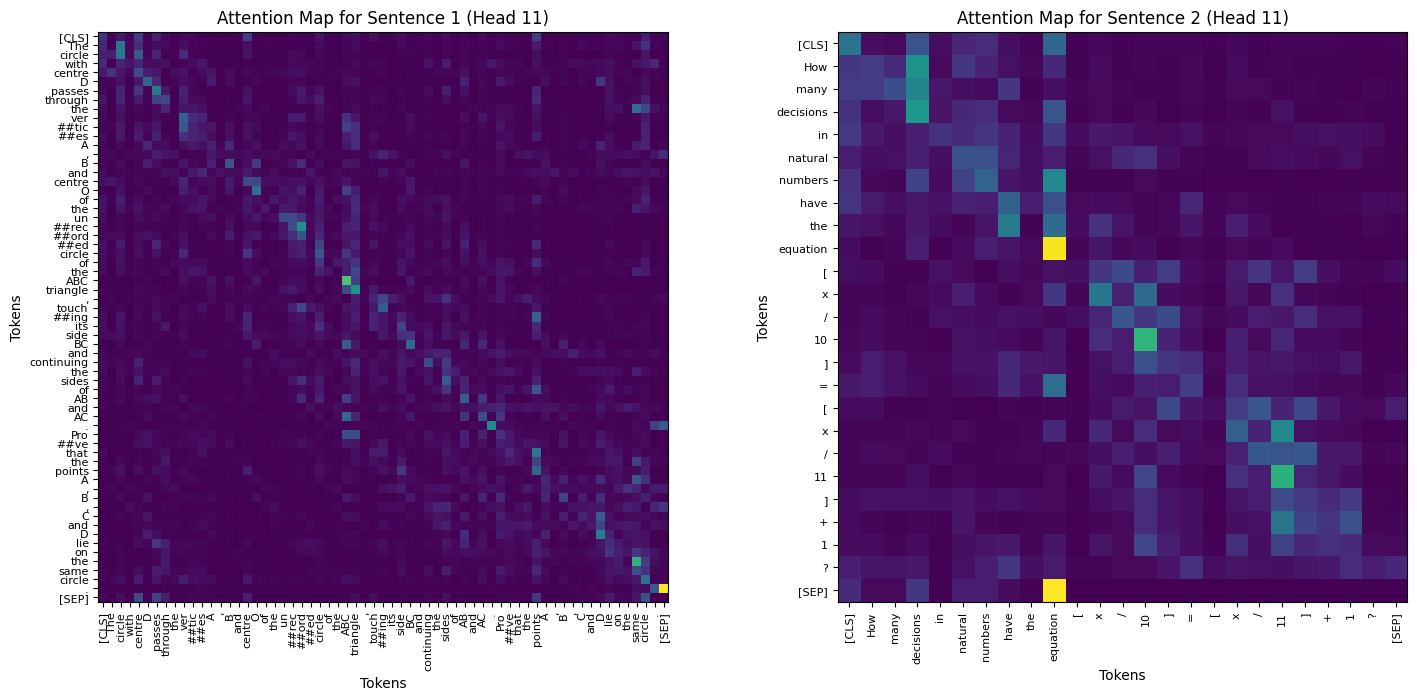

In [45]:
attention_head_id = 11
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, rubert_tiny_freezed_result['model'], bert_model_name)

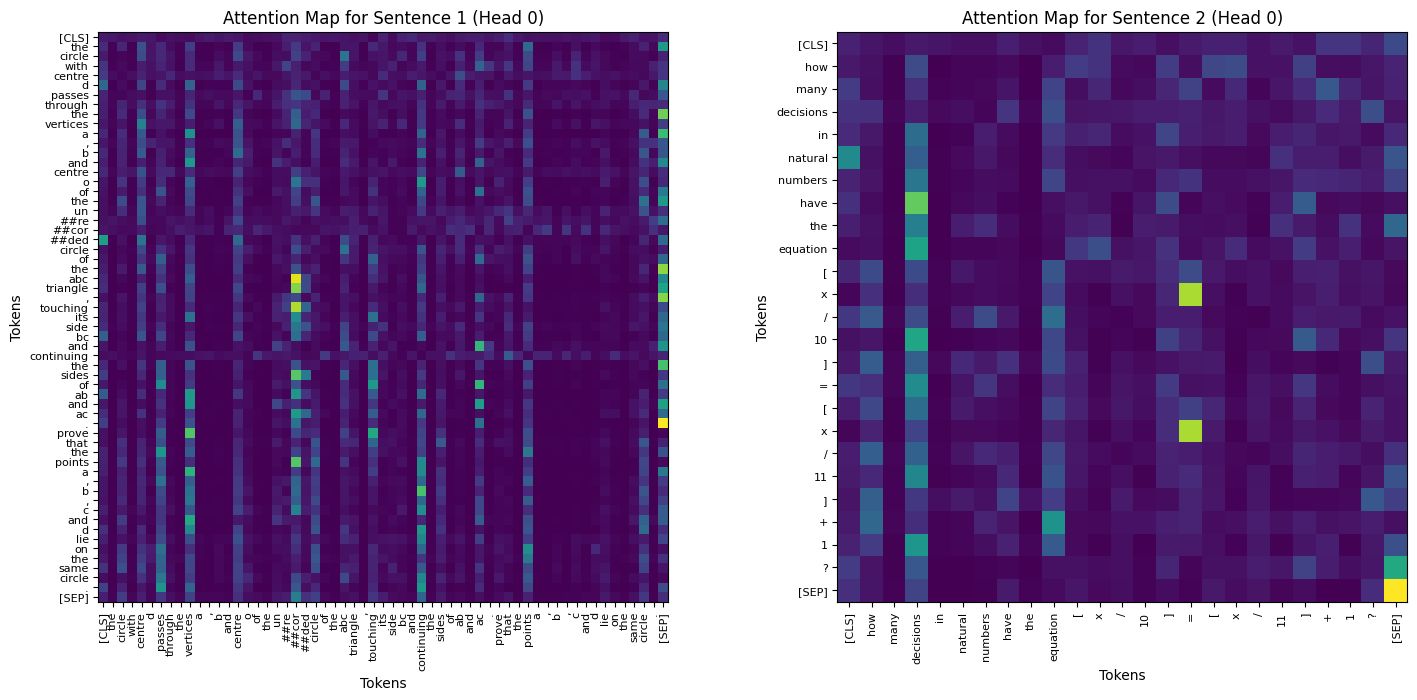

In [46]:
attention_head_id = 0
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, math_freezed_result['model'], math_model_name)

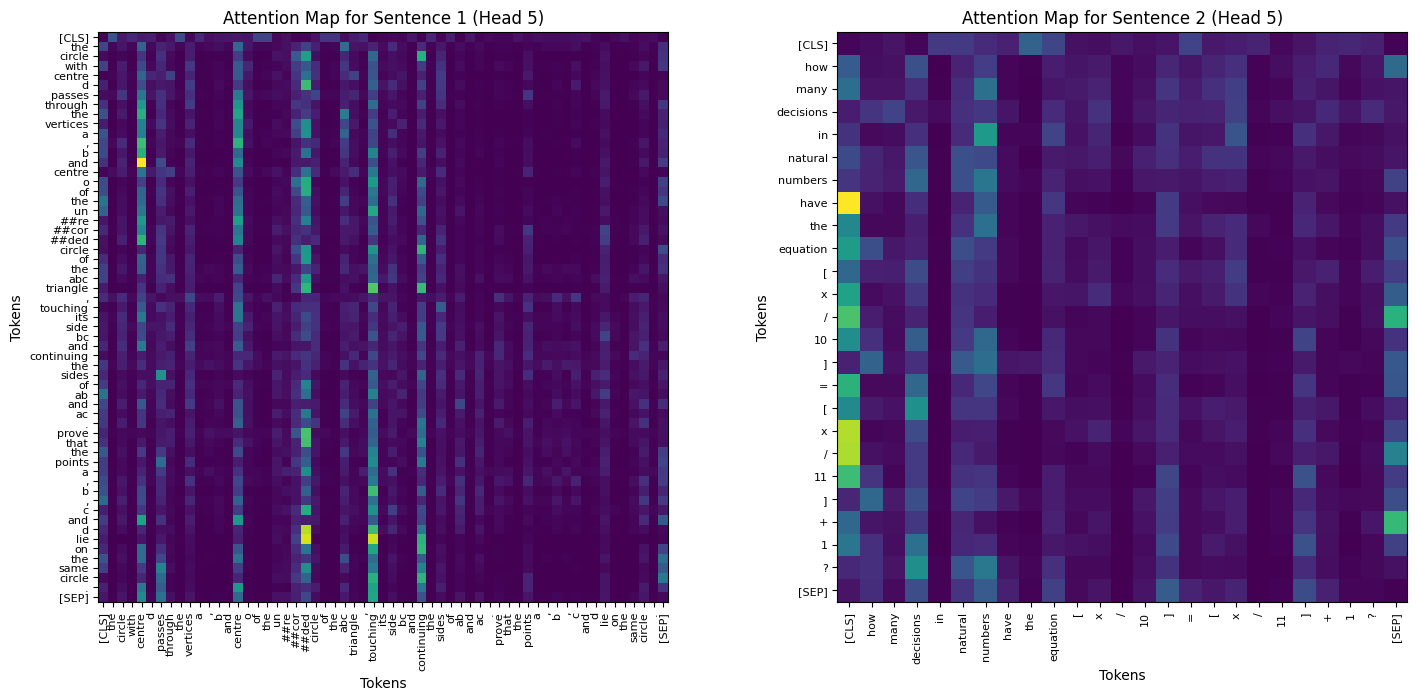

In [47]:
attention_head_id = 5
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, math_freezed_result['model'], math_model_name)

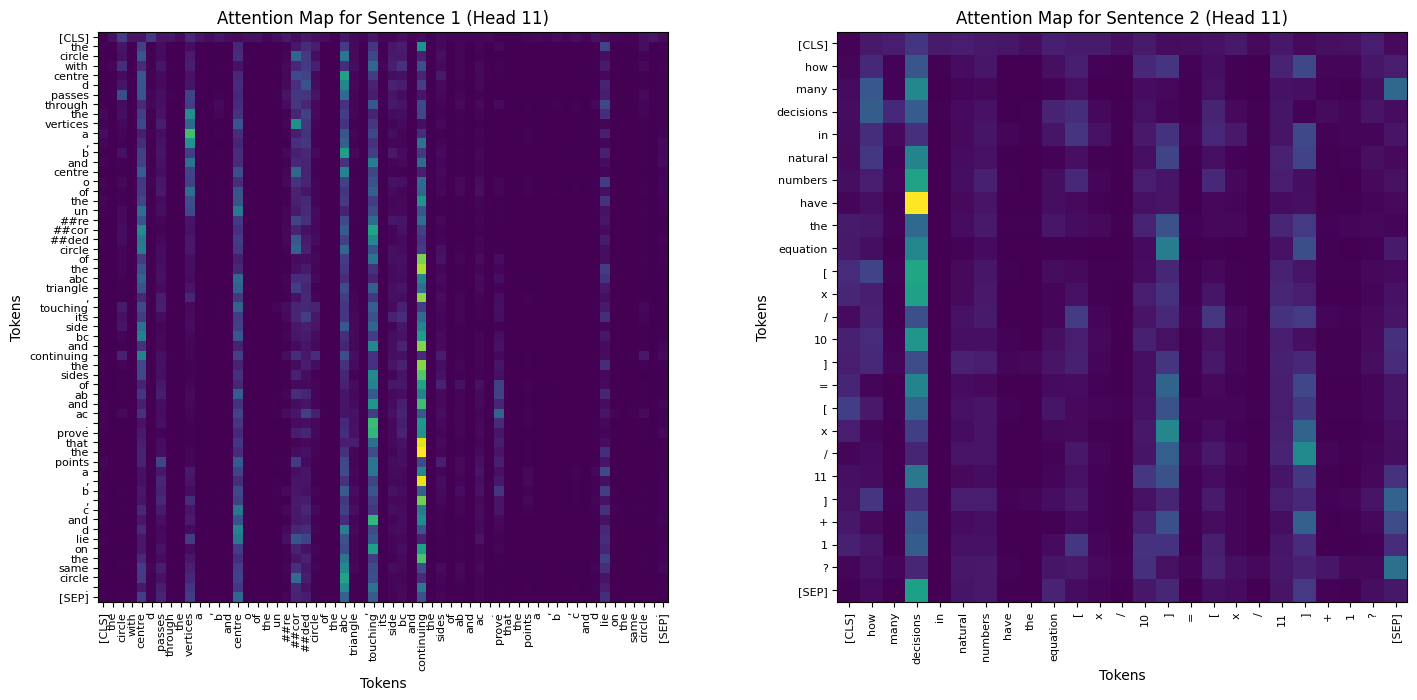

In [48]:
attention_head_id = 11
draw_first_layer_attention_maps(attention_head_id, setence_1, setence_2, math_freezed_result['model'], math_model_name)

# Вывод

1. После просмотра исходных данных, было обнаружено что в датасете содержались тексты, кторые не несли в себе какого-то смыслового значения и более того, появлялись в выборке неоднократно с разными значениями целевых классов. Данный факт играет негативно на дальнейшее обучение модели, поэтому часть таких предложений была удалена.

2. Была обучена модель Tiny-Rubert на 20 эпохах. Из интересного было замечено следущее, когда мы размораживаем backbone, то у нас увеличивается время обучения для одной итерации примерно в 3 раза. С замороженными весами скорость обучения для 1 итерации примерно 6.5 секунды, а с размороженными весами 17.5. Данный факт в каком-то смысле логичен, так как при разморозке у нас резко вырастает кол-во обучаемых параметров и модели, приходится делать "большую" работу отсюда и такое замедление обучения по времении. Более важным фактором было то, что модель с размороженными весами практически не обучалась, её значение лосс функции не снижается и более того, это значение начинает расти. Данный эффект возникает из-за того что мы разморозили все веса, но при этом обучаемых данных у нас крайне мало и модель фактически не может обучаться. Возможно нужно было попробовать различные трюки для стабилизации обучения, однако в данной работе они не использовались. Факт того, что модель с размороженными весами не обучилась подтвердили значения ключевых метрик F1 score. Для модели с замороженными весами: 0.55 с размороженными весами: 0.29 (для напоминаяния, идеальное значение метрики = 1, а самое плохое значение = 0).

3. На следующем этапе была обучена модель tbs17/MathBert которая изначально обучалась на корпусе математических текстов и должна, по идее, показать лучшее качество, чем модель Tiny-Rubert. Время обучения моделей с замороженным backbone и размороженным отличалось примерно в 4 раза 45 секунд на итерацию для замороженного backbone и примерно 200 секунд для размороженнего, причина в целом тут ровно такая же как и в прошлой сети, а именно изменившееся кол-во весов для обучения. При этом качество модели по метрике F1 score осталось примерно такой же как и для модели Rubert-Tiny.

4. По картам ванимания получилась следующая закономерность, модели которые совсем не обучались на нашем датасете, на первых картах показываются в основном связи либо только сами с собой либо со смежными словами, которые чаще всего образуют устойчивые словосочетания, при этом если в предложениях содержатся какие-то формулы, то каких-то связей с другими токенами нет. Если мы идем в более глубокие карты внимания, то в них уже довольно сложно уловить какую-то связь так как становится довольно много шума. Если же мы смотрим на обученные модели на нашем датасете, то замечаем что Math-Bert довольно четко выделяет "математические" слова, например "natural numbers", triangle итд. Тогда как обученный Rubert-Tiny пытается подсветить скорее какие-то общие слова/словосочетания, те действует по сути также как и сеть без обучения.

Краткий вывод. Если необходимо дообучать модель и при этом данных довольно мало, то backbone лучше оставлять тот, который был обучен ранее на большом объеме и только при условии, что кол-во данных у вас начинает расти, имеет смысл пытаться обучить полностью сеть на всех слоях.